# Entrega 3 : kNN y KDE sobre la base de datos MNIST

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

En este trabajo práctico, vamos a utilizar una parte de la famosa base de datos de dígitos escritos a mano del MNIST. Esta se encuentra disponible dentro de sklearn y la importaremos utilizando `load_digits`:

In [2]:
digitos = load_digits()

In [3]:
digitos.data.shape

(1797, 64)

In [8]:
# display(digitos)

Observemos que la base de datos cuenta con 1797 dígitos y 64 variables. Las variables son los valores de cada pixel de la imagen de dimensión (8x8). Es decir, que para poder observar la imagen, debemos reacomodar los pixeles a un array (8x8). A continuación les paso una función que hace esto, utilizando el método `reshape` de numpy.

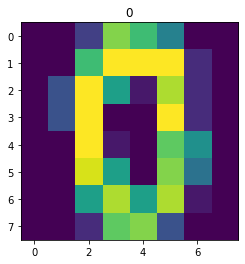

In [38]:
def ver_imagen(caso, data, target):
    plt.title(target[caso])
    plt.imshow(data[caso].reshape((8,8)))

ver_imagen(20, digitos.data, digitos.target)

En el caso anterior, estamos viendo la imagen número 20 de los datos. Tengamos en cuenta que el número 20 es el índice de esta imagen en la base de datos, no el valor del dígito escrito a mano. 

El conjunto de datos cuenta con números entre 0 y 9, como podemos ver a continuación:

In [39]:
digitos.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Y las etiquetas de cada una de las 1979 imágenes se puede encontrar de la siguiente manera:

In [40]:
digitos.target

array([0, 1, 2, ..., 8, 9, 8])

## 1.) a.) Realice un Análisis de Componentes Principales, para reducir la dimensión del problema de 64 a 15 variables (quedarse con las 2 primeras componentes principales). Del total de variabilidad del conjunto de datos, ¿Cuánta variabilidad está siendo contemplada en este plano?


In [41]:
pca = PCA(n_components=2) # instancio la clase PCA
modelo_pca=pca.fit(digitos.data) # corro PCA sobre los datos X 

print('----------------------------------------------------')
print('Porcentaje de varianza explicada por las primeras dos componentes')
print(modelo_pca.explained_variance_ratio_[[0,1]].sum())
print('----------------------------------------------------')


----------------------------------------------------
Porcentaje de varianza explicada por las primeras dos componentes
0.28509364823698335
----------------------------------------------------


En ese plano esta siendo contemplada una variabilidad de 28,5% del total. 

## 1.) b.) Proyecte los 1797 datos sobre las dos primeras componentes principales. Coloree a cada punto según el valor de dígito que corresponde.

Generamos la proyeccion de los datos:

In [42]:
# Aplicamos PCA a los datos sin estandarizar y nos quedamos con una componente.
X_pca = modelo_pca.transform(digitos.data)
print("Tamaño original:   ", digitos.data.shape)
print("Tamaño transformado:", X_pca.shape)

Tamaño original:    (1797, 64)
Tamaño transformado: (1797, 2)


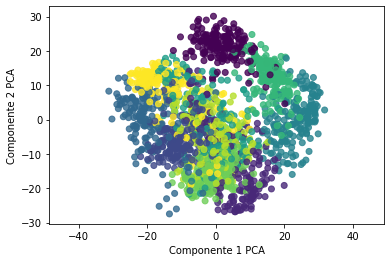

In [43]:
# Reproyectamos los datos con la información de la componente 1 al espacio original.
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=digitos.target, alpha=0.8)
plt.xlabel('Componente 1 PCA') # agregamos nombre al eje abscisas
plt.ylabel('Componente 2 PCA') # agregamos nombre al eje ordenadas
plt.axis('equal'); # definimos que el aspecto del gráfico sea igual para cada eje.

## 2.) a.) Utilice el método de k-vecinos más cercanos para armar un clasificador que pueda predecir el valor de un nuevo dígito escrito a mano (no utilizado para entrenar) según su valor en las primeras dos componentes principales (Recuerden como armar la grilla de puntos en el plano y cómo predecir en cada punto de la grilla). Para encontrar el valor óptimo de $k$, utilice validación cruzada.

Esto no lo vimos en clase, pero para no usar el algoritmo a mano que hicimos, existe también la validación cruzada armada en sklearn. El método se llama [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Por default, este método implementa validación cruzada k-fold con $k=5$. Si se animan, lean la documentación e implementenlo. Sino, utilicen el que hemos hecho en clase o pregunten que les cuento cómo hacer. 

In [44]:
X_train = X_pca
Y_train = digitos.target

In [45]:
#Parameter tuning with GridSearchCV 

#######################
### K-Nearest Neighbors
#######################
estimator_KNN = KNeighborsClassifier(algorithm='auto')
# Parameters grid:
parameters_KNN = {'n_neighbors': list(range(1,11))}
                   
# Parameter tuning with GridSearch
gridsearch=GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    cv = 5
)

gridsearch.fit(X_train,Y_train)

gridsearch.best_estimator_

KNeighborsClassifier(n_neighbors=7)

Encontramos que el mejor K para los datos es de 7.

Ajustamos el modelo

In [46]:
# Punto a predecir
x = np.array([[0.47,1],[7,9],[15,12]])
x.shape

KNN_model=gridsearch.fit(X_train, Y_train)

y_pred_KNN_model =KNN_model.predict(x)

print(y_pred_KNN_model)

[1 5 6]


Supuestas clases predichas de los puntos inventados para predecir.

In [47]:
# Ajusto el mejor modelo
mejor_modelo = KNeighborsClassifier(n_neighbors=7)
mejor_modelo.fit(X_train, Y_train)



KNeighborsClassifier(n_neighbors=7)

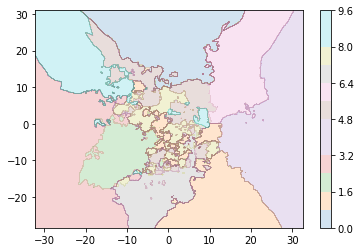

In [55]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = mejor_modelo.predict(np.c_[xx.ravel(), yy.ravel()])
cmap = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, 11, cmap=cmap, alpha=0.2, vmin=0, vmax=9)
plt.colorbar()

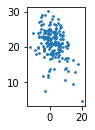

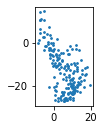

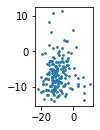

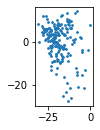

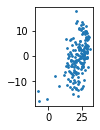

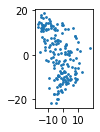

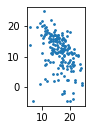

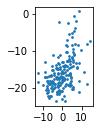

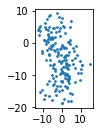

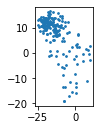

In [56]:
for i in digitos.target_names:
    plt.subplot(2,5,i+1)
    plt.scatter(X_train.T[0][digitos.target==i],X_train.T[1][digitos.target==i],label=str(i),s=3)
    plt.show()

## 3.) Consideremos ahora las primeras 2 componentes principales (contamos con 2 variables). Utilice el método `KernelDensity()` de sklearn para encontrar la estimación de densidad en el espacio de las 2 componentes. Usar un kernel gaussiano y encontrar el valor del ancho de banda óptimo mediante validación cruzada (tomar valores de ancho de banda entre 0.1 y 10).  

In [52]:
# help(KernelDensity())

Busco el valor de bandwith con grid search:

In [49]:
#Parameter tuning with GridSearchCV 

estimator = KernelDensity(kernel ='gaussian')
# Parameters grid:
parameters = {'bandwidth':np.arange(0, 10.01, 0.1)}
                   
# Parameter tuning with GridSearch
gridsearch=GridSearchCV(
    estimator=estimator,
    param_grid=parameters
)

x, y = X_pca[:, 0], X_pca[:, 1]

xy_train  = np.vstack([y, x]).T

gridsearch.fit(xy_train)

gridsearch.best_estimator_

C:\Users\marti\anaconda3\envs\MEA\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [            nan -14686.73458074  -5348.11420052  -3726.10900534
  -3242.74833841  -3037.76287306  -2936.47261476  -2880.33088688
  -2846.60564274  -2825.14993806  -2810.9028171   -2801.11198263
  -2794.18673863  -2789.16981203  -2785.46810451  -2782.70489976
  -2780.63495416  -2779.09430545  -2777.97005969  -2777.18199611
  -2776.67127655  -2776.39345765  -2776.31411066  -2776.40601552
  -2776.64730308  -2777.02017312  -2777.50997168  -2778.10450344
  -2778.79350671  -2779.56824702  -2780.42120035  -2781.34580572
  -2782.33627198  -2783.38742716  -2784.49460129  -2785.65353563
  -2786.86031282  -2788.11130358  -2789.4031266   -2790.73261873
  -2792.09681313  -2793.49292337  -2794.91833183  -2796.3705811
  -2797.84736712  -2799.34653352  -2800.8660663   -2802.40408872
  -2803.95885598  -2805.52874971  -2807.11227212  -2808.70803996
  -2

KernelDensity(bandwidth=2.2)

Planteo la funcion que ploteara los resultados del kernel density

In [50]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(kernel ='gaussian',bandwidth=2.2, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

Hago el plot del kernel density estimado

C:\Users\marti\anaconda3\envs\MEA\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


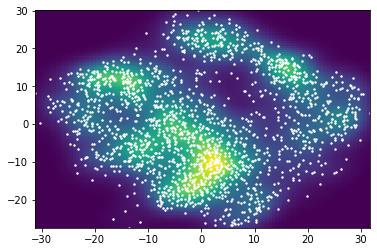

In [51]:
x, y = X_pca[:, 0], X_pca[:, 1]

xx, yy, zz = kde2D(x, y, 5)

plt.pcolormesh(xx, yy, zz)
plt.scatter(x, y, s=2, facecolor='white')

## 3.) b.) la clase `KernelDensity()` de sklearn contiene el método `sample()` que sirve para muestrear la densidad de probabilidad estimada. Utilice este método para obtener una muestra de 10 puntos nuevos de la densidad estimada. Luego, utilice el clasificador kNN entrenado anteriormente para clasificar estos nuevos 10 puntos.

In [52]:
xy_train  = np.vstack([y, x]).T
kde_skl = KernelDensity(kernel ='gaussian',bandwidth=2.2)

# Entreno el modelo
kde=kde_skl.fit(xy_train)

# Hago le sample
x=kde.sample(10,1)

# Predigo con KNN
y_pred_KNN_model =KNN_model.predict(x)

print(y_pred_KNN_model)

[7 3 4 3 2 3 4 6 6 6]


Estos son los grupos predichos.

## 3.)c.) Una vez muestreados y clasificadors los nuevos puntos, utilizar el método `inverse_transform()` de `PCA` para volver los puntos muestreados al espacio de los pixeles. Graficar las nuevas imágenes generadas (puede usar la función ver_imagen)! 

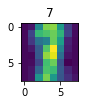

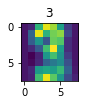

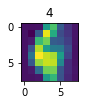

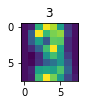

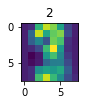

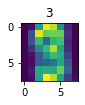

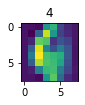

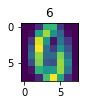

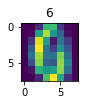

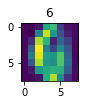

In [54]:
inv_transf = modelo_pca.inverse_transform(x)
inv_transf.shape

for i in range(0,10):
    plt.subplot(2,5,i+1)
    ver_imagen(i, inv_transf, y_pred_KNN_model)
    plt.show()


En resumen, lo que hemos hecho hasta es:

1.) Reducir la dimensión del problema utilizando PCA.

2.) Entrenar un clasificador en el espacio de las primeras dos componentes principales a partir de un conjunto de entrenamiento. 

3.) Utilizar el método no paramétrico KDE para estimar la distribución de probabilidad de los dígitos en el espacio de las primeras componentes principales. 

4.) Muestrear la distribución generada y clasificar los puntos muestrados utilizando el clasificador entrenado. 

5.) Reproyectar los datos nuevos sobre las variables originales (los pixeles) y graficar.

Lo que hemos armado es un modelo GENERATRIZ o GENERATIVO. Esto se llama así ya que sirve para generar nuevas imágenes a partir del conocimiento de las imágenes de entrenamiento.

La calidad de las imágenes obtenidas es pobre, ya que estamos utilizando únicamente las primeras dos componentes principales para muestrear en el KDE y reconstruir la imágen. Esto se debe a que hemos reducido fuertemente la dimensión del problema. Esta parte que sigue no será evaluada y no es necesaria, pero recomiendo que prueben quedarse con las primeras 20 componentes principales (va a haber 64 componentes principales, tantas como variables), estimen la densidad con KDE utilizando las 20 variables y muestreen la distribución de probabilidad obtenida. Verán que la reconstrucción al realizar la transformación inversa del PCA será mucho más fiel a los datos entrenados (nos estamos quedando con mayor variabilidad de los datos, por lo tanto mayor información). 